# About

Numerical plots pertaining to trials of a simplified 2-dim Kuramoto system with adaptive delays and no self-feedback links. Requires a folder of .mat files from the the following scripts:
 - script2D_iter.m

Uses the following packages and functions:

# Library

In [1]:
from __future__ import division, print_function

%matplotlib inline
# Toggle on/off
# %matplotlib notebook

import os
import numpy as np
import scipy.io as sio
from scipy import optimize
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.transforms as tsfm
import math
from math import pi

from lib import *

from IPython.display import clear_output

# Directories

In [2]:
# Data files (for fig.4d)
import_folder = 'matlab2D_multi'
export_folder = 'export'
ex_name = '2D_process'

# Directory
dir_main = os.getcwd()
dir_im = os.path.join(dir_main, 'data', import_folder)
dir_ex = os.path.join(dir_main, 'data', export_folder)

filenames = os.listdir(dir_im)

# Import and compile data

## Constant parameters

In [3]:
dir_sam = os.path.join(dir_im, filenames[0])
dict_mat = sio.loadmat(dir_sam)

param = {'g': dict_mat['g'][0,0],
         'omega0': dict_mat['omega0'][0,0],
         'gain': dict_mat['gain'][0,0],
         'tf': dict_mat['tf'][0,0],
         'tau0': dict_mat['tau0'][0,0],
         }

# Asymptotic percentage
asy = 0.1

## Asymptotic values

In [4]:
# Compiled arrays
init_freqs = np.zeros(len(filenames))
init_Deltas = np.zeros(len(filenames))
asy_freqs = np.zeros(len(filenames))
asy_Deltas = np.zeros(len(filenames))
var_freqs = np.zeros(len(filenames))

for i in range(len(filenames)):
    
    # Import .mat file
    dir_mat = os.path.join(dir_im, filenames[i])
    dict_mat = sio.loadmat(dir_mat)
    
    # Compile solution dictionary
    sol = {'t': np.reshape(dict_mat['t'], -1),
           'y': dict_mat['y'],
           'yp': dict_mat['yp'],
           'tau': dict_mat['tau'],
           'taup': dict_mat['taup']
          }
    
    init_freq = dict_mat['init_freq'][0,0]
    init_Delta = dict_mat['Delta0'][0,0]
    
    # Compute the global frequency:
    arr_omega = asylib.weight_avg(sol['t'], sol['yp'], asy)
    asy_Omega = np.sum(arr_omega) / arr_omega.size

    Omega_vars = asylib.weight_avg(sol['t'], (sol['yp'] - asy_Omega)**2, asy)
    Omega_var = np.sum(Omega_vars)

    # Get array of asymptotic phases:
    arr_lin = asy_Omega*sol['t']
    arr_lin = arr_lin[:,None]

    arr_phases = sol['y'] - arr_lin
    asy_phases = asylib.weight_avg(sol['t'], arr_phases, asy)

    # Variance
    phase_vars = asylib.weight_avg(sol['t'], (arr_phases - asy_phases)**2, asy)
    phase_var = np.sum(phase_vars)
    
    # SAVE TO ARRAYS
    init_freqs[i] = init_freq
    init_Deltas[i] = init_Delta
    asy_freqs[i] = asy_Omega
    asy_Deltas[i] = np.abs(asy_phases[1] - asy_phases[0])
    var_freqs[i] = Omega_var
    
    # Print statements:
    print("Trial: " + filenames[i] + ', asy. freq = ' + str(asy_Omega))

Trial: 2D_num_0.mat, asy. freq = 0.9170227553619007
Trial: 2D_num_1.mat, asy. freq = 0.9170205077838434
Trial: 2D_num_10.mat, asy. freq = 0.9170210291791165
Trial: 2D_num_11.mat, asy. freq = 0.6572031429215399
Trial: 2D_num_12.mat, asy. freq = 0.6571993504902667
Trial: 2D_num_13.mat, asy. freq = 0.6572024870240645
Trial: 2D_num_14.mat, asy. freq = 0.657201937946093
Trial: 2D_num_15.mat, asy. freq = 0.6572001277886079
Trial: 2D_num_16.mat, asy. freq = 0.6572030685538071
Trial: 2D_num_17.mat, asy. freq = 0.6572024106525862
Trial: 2D_num_18.mat, asy. freq = 0.65720221675804
Trial: 2D_num_19.mat, asy. freq = 0.6571995124900978
Trial: 2D_num_2.mat, asy. freq = 0.9170295155080644
Trial: 2D_num_20.mat, asy. freq = 0.6572004863038834
Trial: 2D_num_21.mat, asy. freq = 0.6572006109352929
Trial: 2D_num_22.mat, asy. freq = 0.6572031014667938
Trial: 2D_num_23.mat, asy. freq = 0.6572010449737863
Trial: 2D_num_24.mat, asy. freq = 0.6572020011277735
Trial: 2D_num_25.mat, asy. freq = 0.6572031290988753

## Theoretical asy values

In [5]:
Omega_fun = lambda Omega: funlib.Omega2D(Omega, param)[0]
Delta_fun = lambda Omega: funlib.Omega2D(Omega, param)[1]

# Parameters
w0 = param['omega0']
g = param['g']
tau0 = param['tau0']

# Get all roots of Omega_fun in region
Omega_roots = rootlib.root_on_interval(Omega_fun, w0-g/2, w0+g/2, steps=500)
Delta_roots = np.zeros(Omega_roots.size)

for i in range(Omega_roots.size):
    Delta_roots[i] = Delta_fun(Omega_roots[i])

## Export

In [6]:
# Define export dictionary
ex_mat = {'eq_freqs': Omega_roots,
          'eq_Deltas': Delta_roots,
          'init_freqs': init_freqs,
          'init_Deltas': init_Deltas,
          'asy_freqs': asy_freqs,
          'asy_Deltas': asy_Deltas,
          'var_freqs': var_freqs,
          'g': param['g'],
          'w0': param['omega0'],
          'tau0': param['tau0']
          }

# Copy parameters
for par in param.keys():
    ex_mat[par] = param[par]

# Export to .mat (export folder)
dir_exfile = os.path.join(dir_ex, ex_name)
sio.savemat(dir_exfile, ex_mat)

# Arrays over time

Skip to this cell if asymptotic arrays have already been processed.

In [7]:
# Import from folder2 with at least two trials (converging to different frequencies
trial1 = {'color': 'blue', 'name': '2D_num_6'}
trial2 = {'color': 'red', 'name': '2D_num_44'}

### Trial 1

In [8]:
dir_mat1 = os.path.join(dir_im, trial1['name'])
dict_mat1 = sio.loadmat(dir_mat1)

trial1['t'] = np.reshape(dict_mat1['t'], -1)
trial1['y'] = dict_mat1['y']
trial1['yp'] = dict_mat1['yp']
trial1['tau'] = dict_mat1['tau']
trial1['init_freq'] = dict_mat1['init_freq'][0,0]
trial1['Delta0'] = dict_mat1['Delta0'][0,0]

# Compute the asymptotic arrays
arr_omega1 = asylib.weight_avg(trial1['t'], trial1['yp'], asy)
asy_Omega1 = np.sum(arr_omega1) / arr_omega1.size


sol1 = {'t': np.reshape(dict_mat1['t'], -1),
       'y': dict_mat1['y'],
       'yp': dict_mat1['yp'],
       'tau': dict_mat1['tau'],
       'taup': dict_mat1['taup']
      }

# Get array of asymptotic phases:
arr_lin1 = asy_Omega1*sol1['t']
arr_lin1 = arr_lin1[:,None]

arr_phases1 = trial1['y'] - arr_lin1
asy_phases1 = asylib.weight_avg(trial1['t'], arr_phases1, asy)

# Store
trial1['phases'] = arr_phases1
trial1['asy_phases'] = asy_phases1
trial1['asy_Omega'] = asy_Omega1

### Trial 2

In [9]:
dir_mat2 = os.path.join(dir_im, trial2['name'])
dict_mat2 = sio.loadmat(dir_mat2)

trial2['t'] = np.reshape(dict_mat2['t'], -1)
trial2['y'] = dict_mat2['y']
trial2['yp'] = dict_mat2['yp']
trial2['tau'] = dict_mat2['tau']
trial2['init_freq'] = dict_mat2['init_freq'][0,0]
trial2['Delta0'] = dict_mat2['Delta0'][0,0]

# Compute the asymptotic arrays
arr_omega2 = asylib.weight_avg(trial2['t'], trial2['yp'], asy)
asy_Omega2 = np.sum(arr_omega2) / arr_omega2.size


sol2 = {'t': np.reshape(dict_mat2['t'], -1),
       'y': dict_mat2['y'],
       'yp': dict_mat2['yp'],
       'tau': dict_mat2['tau'],
       'taup': dict_mat2['taup']
      }

# Get array of asymptotic phases:
arr_lin2 = asy_Omega2*sol2['t']
arr_lin2 = arr_lin2[:,None]

arr_phases2 = trial2['y'] - arr_lin2
asy_phases2 = asylib.weight_avg(trial2['t'], arr_phases2, asy)

# Store
trial2['phases'] = arr_phases2
trial2['asy_phases'] = asy_phases2
trial2['asy_Omega'] = asy_Omega2

# Asymptotic arrays

In [10]:
# Import arrays and values
dir_exfile = os.path.join(dir_ex, ex_name)
dict_ex = sio.loadmat(dir_exfile)

eq_freqs = np.reshape(dict_ex['eq_freqs'], -1)
eq_Deltas = np.reshape(dict_ex['eq_Deltas'], -1)
init_freqs = np.reshape(dict_ex['init_freqs'], -1)
init_Deltas = np.reshape(dict_ex['init_Deltas'], -1)
asy_freqs = np.reshape(dict_ex['asy_freqs'], -1)
asy_Deltas = np.reshape(dict_ex['asy_Deltas'], -1)

# Plot

## Options

In [11]:
# Plot positions [left, bottom, width, height] 
bbox0 = [0.15, 0.7, 0.35, 0.20]  # Fig 2a: Derivative plots
bbox1 = [0.15, 0.4, 0.35, 0.20]  # Fig 2b: sin(phase) plots
bbox2 = [0.15, 0.1, 0.35, 0.20] # Fig 2c: Delay plots
bbox3 = [0.60, 0.1, 0.45, 0.8] # Fig 2d: Iterated trial plot

# Figure a,b,c lines
line_opts = {'linewidth': 1.2,
             'alpha': 0.6
            }

tf = np.max(trial1['t'])/3

# Dotted lines (linking initial to asy points in fig.d)
dotopts = {'linestyle': '-',
           'linewidth': 0.5,
           'marker': None,
           'color': 'black',
           'alpha': 0.5
          }

## Generate figure

(0.0, 200.0)

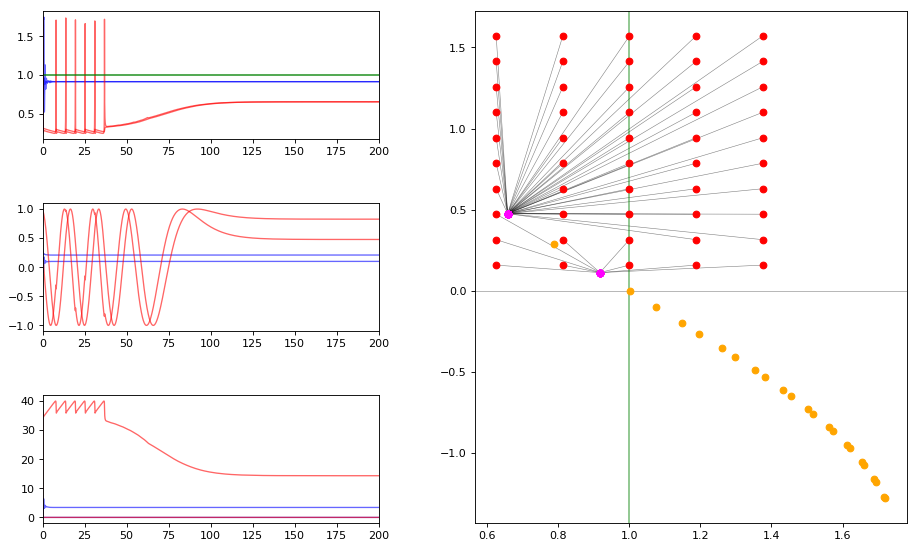

In [12]:
fig, ax = plt.subplots(4, figsize=(12,8), dpi=80)

# Set positions
ax[0].set_position(bbox0)
ax[1].set_position(bbox1)
ax[2].set_position(bbox2)
ax[3].set_position(bbox3)

# Trial 1:
ax[0].plot(trial1['t'], trial1['yp'], color=trial1['color'], **line_opts)
ax[1].plot(trial1['t'], np.sin(trial1['phases']), color=trial1['color'], **line_opts)
ax[2].plot(trial1['t'], trial1['tau'], color=trial1['color'], **line_opts)

# Trial 2:
ax[0].plot(trial2['t'], trial2['yp'], color=trial2['color'], **line_opts)
ax[1].plot(trial2['t'], np.sin(trial2['phases']), color=trial2['color'], **line_opts)
ax[2].plot(trial2['t'], trial2['tau'], color=trial2['color'], **line_opts)

ax[0].axhline(y=dict_ex['w0'], color='green', alpha=0.8, linewidth=1.5)

for k in range(init_freqs.size):
    p1 = np.array([init_freqs[k], asy_freqs[k]])
    p2 = np.array([init_Deltas[k], asy_Deltas[k]])
    ax[3].plot(p1, p2, **dotopts, zorder=-2)
    
ax[3].scatter(init_freqs, init_Deltas, color='red', zorder=-1)
ax[3].scatter(asy_freqs, asy_Deltas, color='magenta', zorder=1)
ax[3].scatter(eq_freqs, eq_Deltas, color='orange', zorder=0)

ax[3].axvline(x=dict_ex['w0'], color='green', alpha=0.5, zorder=-2)
ax[3].axhline(y=0, color='black', alpha=0.5, linewidth=0.5, zorder=-2)

# Adjustments to axes
ax[0].set_xlim(left=np.min(trial1['t']), right=tf)
ax[1].set_xlim(left=np.min(trial1['t']), right=tf)
ax[2].set_xlim(left=np.min(trial1['t']), right=tf)

In [13]:
print(trial1['color'] + ' freq: ' + str(trial1['asy_Omega']) + ', initial phase diff: ' + str(trial1['Delta0']))
print(trial2['color'] + ' freq: ' + str(trial2['asy_Omega']) + ', initial phase diff: ' + str(trial2['Delta0']))

blue freq: 0.917019959742905, initial phase diff: 0.3141592653589793
red freq: 0.657201315977068, initial phase diff: 1.413716694115407
